In [10]:
##Import some modules used for this notebook.
from get_save_directory import get_save_dir
from make_dataset import make_dataset
from normalization import Normalization
from make_train_test_dataset import MakeTrainTestDataset
from artificial_neural_network import ArtificialNeuralNetwork
import os, sys, shutil
import numpy as np
import copy as cp
import pickle

In [5]:
##Print a dir_list which is a list of ectracted parameters.
##The parameters are made by ./parameter/MakePickleOfParam.ipynb.
dir_list = np.loadtxt("param_list.txt", dtype = "str")
for i in range(len(dir_list)):
    print("{}. {}".format(i, dir_list[i]))

0. param_1e+6_1e+18_ScaleFactor_ID_pid_Mvir_Rvir_x_vx_MW039_MW038.pickle
1. param_1e+7_1e+18_ScaleFactor_ID_pid_Mvir_Rvir_x_vx_MW039_MW038.pickle


In [6]:
##Input index-number of param_list.txt in dir_num to select it.
##Load the parameters of host-halo and sub-halo.
dir_num = int(input("\nSelect index>> "))
with open("parameters/" + dir_list[dir_num], mode = "rb") as f:
    param = pickle.load(f)
with open("parameters/host_" + dir_list[dir_num], mode = "rb") as f:
    host_param = pickle.load(f)


Select index>> 0


In [7]:
##The list of used parameters and host-halo.
param_list = list(param.keys())
mainbranch_list = list(param[param_list[0]].keys())
print(param_list)
print(mainbranch_list)

['ScaleFactor', 'ID', 'pid', 'Mvir', 'Rvir', 'x', 'vx']
['mainbranch_MW039.csv', 'mainbranch_MW038.csv']


In [8]:
##Get zacc of each sub-halo as acc_sf(Data type is dictionary).
##The zacc is a time when ID of host-halo and pid of sub-halo match.
acc_sf = {}
for m_key in mainbranch_list:
    acc_sf[m_key] = []
    for idx, parameter in enumerate(param["pid"][m_key]):
        for i in range(parameter.size):
            host_i = host_param["ID"][m_key].size - parameter.size + i
            if host_param["ID"][m_key][host_i] == parameter[i]:
                acc_sf[m_key].append(i)
                break
            elif i == parameter.size-1:
                acc_sf[m_key].append(-1)

In [2]:
##Describe variables of learning-parameter of a DeepLearningModel in LearnParam.
class LearnParam:
    def __init__(self):
        self.eps = 1.0  ##Prevent devision by zero like 1 / (0 + eps).
        self.bias = True ##If This bias is True, add normalized dataset to bias.
        self.hidden = [100]*5  ##Defines number of hidden layers and neurons in each layers.
        self.batchsize_denominator = 200  ##Defines a size of mini-batch as size(train-dataset) /  batch_denominator.
        self.learning_rate = "1e-3"  ##Learning rate of Back propagation.
        self.optimizer = "Adam"  ##Optimizer of the DeepLearningModel.
        self.batch_normalization = True  ##Whether to use BatchNormalization or not.
        self.loss_func = "MSE_RE"  ##Loss function of a DeepLearning model.
        self.activation_func = "relu"  ##Activation function of the hidden layers.
        self.weight_init = "he"  ##Condition for initializing weight of the hidden layers.
        self.lastlayer_identity = True
        self.epoch = 200  ##Training epoch.
        self.input_size = 2  ##Size of input-dataset(axis == 1)
        self.output_size = 7  ##Size of output-dataset(axis == 1)
        self.param_kind = "x"  ##Learning parameter.
        self.train_ratio = 0.7  ##Percentage of training-dataset to all-dataset.
        self.normalize_format = "Normalization"  ##Selects a format of dataset normalization in None, Normalization, Standardization.
        self.extract_dataset = "After_acc"  ##Selects a condition of dataset.
        ##All is overall, Before/After_acc is in part of before/after accretion, All(_not)_acc is overall of (not)accreted sub-halo.
        self.learn_num = 1  ##Distinguishes the directories where training results are saved.
        self.save_fig_type = ".png"  ##Format of the saved figures.

In [11]:
LP = LearnParam()
dataset = make_dataset(mainbranch_list, LP.param_kind, host_param, param, LP.extract_dataset, acc_sf)
Norm = Normalization(mainbranch_list, LP.normalize_format, LP.bias, LP.eps)
dataset_normed = Norm.run(dataset)
MTTD = MakeTrainTestDataset(mainbranch_list)
train, test = MTTD.split(cp.deepcopy(dataset_normed), LP.train_ratio)

m_list : ['mainbranch_MW039.csv', 'mainbranch_MW038.csv']
norm_format : Normalization
bias : True
eps : 1.0


In [12]:
ANN = ArtificialNeuralNetwork(LP.input_size, LP.hidden, LP.activation_func, LP.weight_init, LP.batch_normalization, LP.output_size, LP.lastlayer_identity, LP.loss_func)

In [13]:
ANN.learning(cp.deepcopy(train), cp.deepcopy(test), LP.optimizer, LP.learning_rate, LP.batchsize_denominator, LP.epoch, mainbranch_list)

Save directory is 2in_7out/x_5layers_100neurons_BatchNorm_MSE_RE_1e-3lr_200_Normalization_After_acc/.


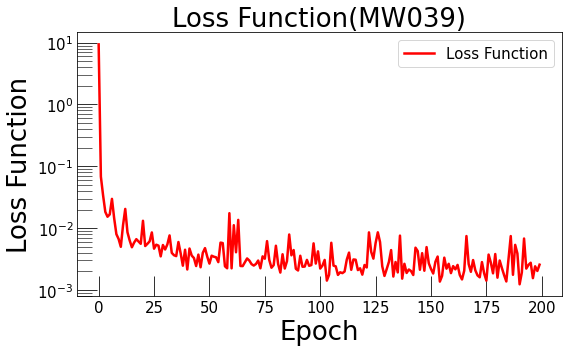

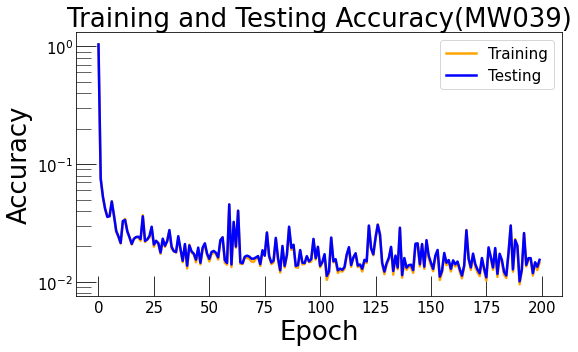

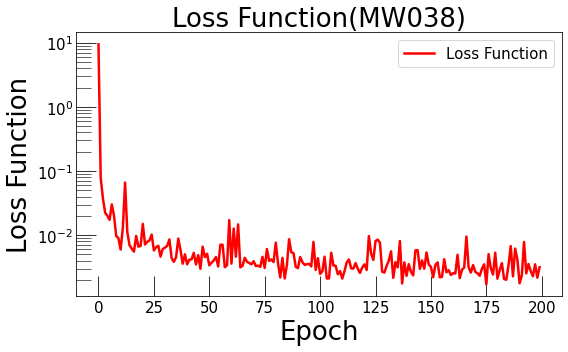

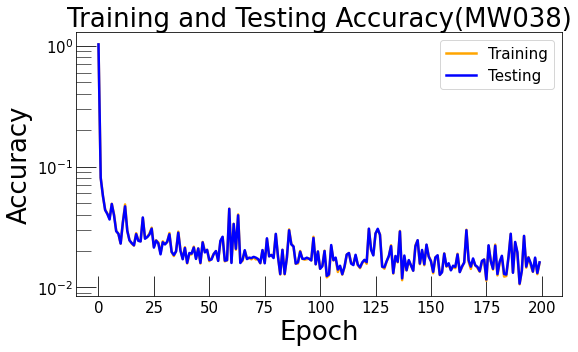

In [14]:
save_dir = get_save_dir(LP)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    print("Make a directory {}.".format(save_dir))
else:
    print("Save directory is {}.".format(save_dir))
ANN.plot_figures(save_dir, LP.save_fig_type)

In [15]:
prediction = ANN.predict(cp.deepcopy(dataset_normed))